In [1]:
from active_model import MLP, Conv
import active_model
import generate_data
import numpy as np
import math
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [25]:
torch.manual_seed(0)


In [2]:
shared_features = ['v', 'q', 'pwm', 'hover_throttle', 't']
raw_data, options = generate_data.load_data(features = ['v', 'q', 'pwm', 'hover_throttle', 't'])

In [3]:
options["dim_x"] = 0
for f in shared_features:
  if len(raw_data[0][f].shape) < 2:
    options["dim_x"] += 1
  else:
    options["dim_x"] += raw_data[0][f].shape[1]

In [4]:
hidden_dim = [32,32]
num_task = 6
spectral_norms = [False]*len(hidden_dim)
data_model = MLP(options["dim_x"], 6, hidden_dim, spectral_norms, num_task, True, False)

In [5]:
rng = np.tile([10], [1,49])
rng2 = np.arange(10,500,10)
# shared_features = options["features"]


In [6]:
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500, False)

## Best

In [26]:
shared_features = options["features"]
v = [1,0,0,0,0,0]

In [27]:
best_epoch_loss = []
best_predict_loss = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
best_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9) 
for sample_size in rng[0]:
  total_size += sample_size
  # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = total_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = round(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(best_model, train_dataset, 6, optimizer, i, False)
    scheduler.step()
  best_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(best_model.predict(test_dataset[0],test_dataset[1],k))
  best_predict_loss.append(predict_loss)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset)
  train_dataset = (train_x, train_y)

Text(0.5, 1.0, 'best sampling training loss')

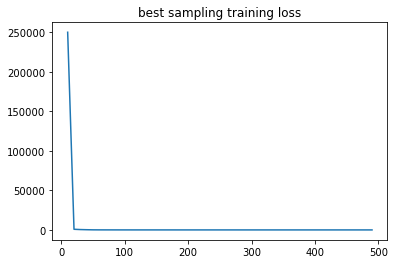

In [28]:
plt.plot(rng2,best_epoch_loss)
plt.title("best sampling training loss")

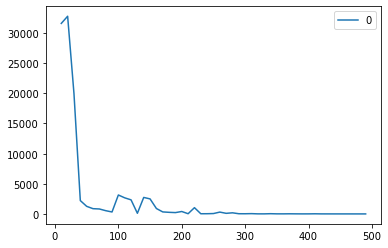

In [29]:
# target nn last layer loss
plt.plot(rng2, np.array(best_predict_loss).T[0], label=0)
plt.legend()
plt.show()

## Uniform

In [30]:
num_task = 6
shared_features = options["features"]
v = np.array([1]*len(raw_data))
v = v / (len(raw_data))
sample_size = 500

In [31]:
uni_epoch_loss = []
uni_predict_loss = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
uni_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
optimizer = optim.SGD(uni_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
for sample_size in rng[0]:
  total_size += sample_size
  # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = total_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(uni_model, train_dataset, 6, optimizer, i, False)
    scheduler.step()
  uni_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(uni_model.predict(test_dataset[0],test_dataset[1],k))
  uni_predict_loss.append(predict_loss)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset)
  train_dataset = (train_x, train_y)
  

Text(0.5, 1.0, 'uniform sampling training loss')

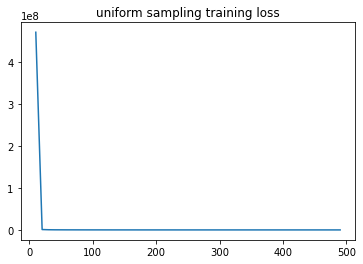

In [32]:
plt.plot(rng2,uni_epoch_loss)
plt.title("uniform sampling training loss")

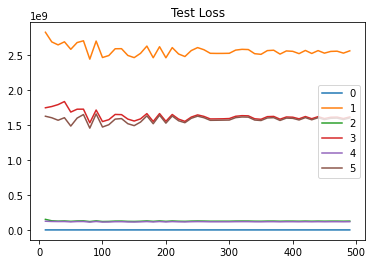

In [33]:
# last layer loss
for k in range(num_task):
    plt.plot(rng2, np.array(uni_predict_loss).T[k], label=k)
plt.legend()
plt.title("Test Loss")
plt.show()

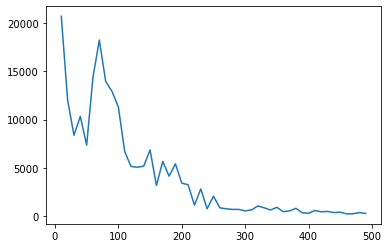

In [34]:
# target nn last layer
plt.plot(rng2, np.array(uni_predict_loss).T[0], label=0)

## Compare

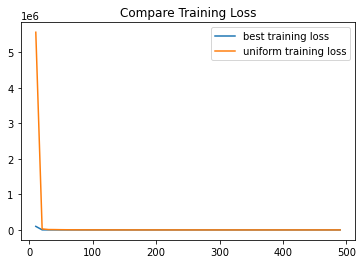

In [38]:
plt.plot(rng2,best_epoch_loss, label="best training loss")
plt.plot(rng2,uni_epoch_loss, label="uniform training loss")
plt.title("Compare Training Loss")
plt.legend()
plt.show()

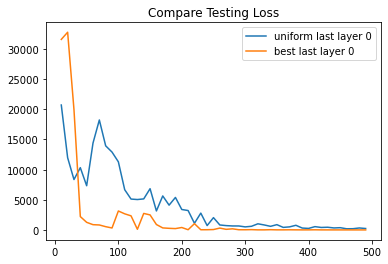

In [35]:
plt.plot(rng2, np.array(uni_predict_loss).T[0], label="uniform last layer 0")
plt.plot(rng2, np.array(best_predict_loss).T[0], label="best last layer 0")
plt.title("Compare Testing Loss")
plt.legend()
plt.show()

## Active

In [38]:
def update_v(ws, best_w):
  new_v = np.linalg.lstsq(ws.detach().numpy(), best_w.detach().numpy().T)[0]
  new_v = new_v.T
  new_v = np.abs(new_v/np.linalg.norm(new_v,2))
  return new_v

def estimate(model, input, true_y, num_task, v):
  results = []
  for task_id in range(num_task):
    result = model.predict(input, true_y, task_id)
    results.append(result)
  best_w_idx = np.argmin(results)
  # print(ws)
  # print(best_w_idx)
  # best_w = ws[best_w_idx]
  ws = torch.ones_like(model.last_layers[0].weight)
  ws = ws.tile(num_task,1)
  for i, layer in enumerate(model.last_layers[1:]):
    ws[i] = layer.weight
    if best_w_idx == i:
      best_w = layer.weight
  new_v = update_v(ws, best_w)
  # if not len(new_v.shape) == 1:
  #   new_v = new_v[0]
  new_v = np.squeeze(new_v)
  v = 0.8 * v + 0.2 * new_v
  # v = np.array([1]*len(RawData))
  # v = v / (len(RawData))
  v = np.apply_along_axis(lambda x: max(0.167, x), 0, [v])
  v = np.squeeze(v)
  # if not len(v.shape) == 1:
  #   v = v[0]
  return v, best_w

In [39]:
def active_sampling(model, test_dataset,num_task, scheduler, sample_size, v):
  train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, int(sample_size*0.6), shared_features, v)
  total_loss = 0
  # for i, p in enumerate(np.tile([0.2],3)):
  task_sample_size = round(sample_size*p)
  L = 1.1  
  K = 70
  M = train_dataset[1][0].shape[0]
  epoch = int(math.log(K*M,L))
  for e in range(epoch):
    total_loss += active_model.train_source(model, train_dataset, 6, optimizer, e, False)
    scheduler.step()
  v, best_w = estimate(model, test_dataset[0], test_dataset[1], num_task, v)
  # print("best_w", best_w)
  # print("after", v)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, task_sample_size, v, shared_features, task_data=train_dataset)
  train_dataset = (train_x, train_y)
  return v, total_loss

In [40]:
v = np.array([1]*len(raw_data))
v = v / (len(raw_data))

In [41]:
active_rng = np.arange(100,500,100)

In [42]:
# active_epoch_loss = []
# active_predict_loss = []
# # test data is small portion of data fomr target taskzs
# # test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
# test_dataset = (test_data, test_label)
# for sample_size in rng:  
#   hidden_dim = [32,32]
#   spectral_norms = [False]*len(hidden_dim)
#   ac_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
#   optimizer = optim.SGD(ac_model.parameters(), lr=0.01, momentum=0.9)
#   scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
#   # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
#   # M = sample_size
#   # L = 1.1   # base length
#   # K = 70   # model dimension
#   # epoch = int(math.log(K*M,L))
#   v, total_loss = active_sampling(ac_model, test_dataset,num_task, scheduler, sample_size, v)
#   active_epoch_loss.append(total_loss/epoch)
#   predict_loss = []
#   for k in range(num_task):
#     predict_loss.append(ac_model.predict(test_dataset[0],test_dataset[1],k))
#   active_predict_loss.append(predict_loss)

In [48]:
active_epoch_loss = []
active_predict_loss = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
ac_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
optimizer = optim.SGD(ac_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
for sample_size in rng[0]:
  total_size += sample_size
  # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = total_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(ac_model, train_dataset, 6, optimizer, i, False)
    scheduler.step()
  active_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(ac_model.predict(test_dataset[0],test_dataset[1],k))
  active_predict_loss.append(predict_loss)
  v, best_w = estimate(ac_model, test_dataset[0], test_dataset[1], num_task, v)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset)
  train_dataset = (train_x, train_y)
  

<ipython-input-38-3a329cf69a2b>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  new_v = np.linalg.lstsq(ws.detach().numpy(), best_w.detach().numpy().T)[0]


Text(0.5, 1.0, 'active sampling training loss')

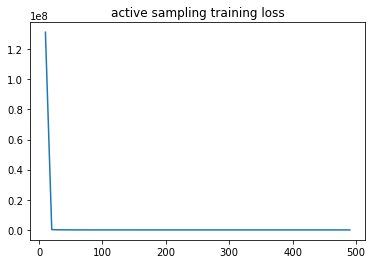

In [49]:
plt.plot(rng2,active_epoch_loss)
plt.title("active sampling training loss")

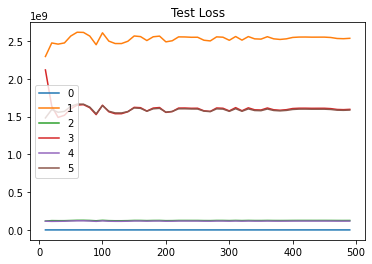

In [50]:
for k in range(num_task):
    plt.plot(rng2, np.array(active_predict_loss).T[k], label=k)
plt.legend()
plt.title("Test Loss")
plt.show()

## Compare

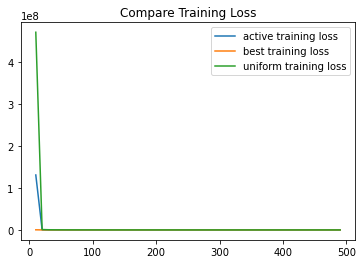

In [51]:
plt.plot(rng2,active_epoch_loss, label="active training loss")
plt.plot(rng2,best_epoch_loss, label="best training loss")
plt.plot(rng2,uni_epoch_loss, label="uniform training loss")
plt.title("Compare Training Loss")
plt.legend()
plt.show()

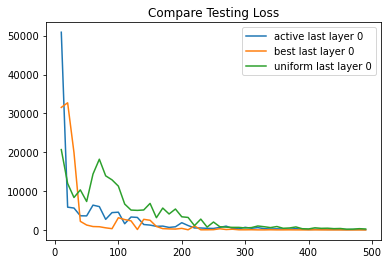

In [52]:
plt.plot(rng2, np.array(active_predict_loss).T[0], label="active last layer 0")
# plt.plot(active_rng, np.array(active_predict_loss).T[5], label="active last layer 0")
plt.plot(rng2, np.array(best_predict_loss).T[0], label="best last layer 0")
plt.plot(rng2, np.array(uni_predict_loss).T[0], label="uniform last layer 0")

plt.title("Compare Testing Loss")
plt.legend()
plt.show()

In [54]:
ac_model.last_layers[1].weight

Parameter containing:
tensor([[-0.6674, -1.1989, -2.2493,  0.4431,  0.1559,  1.2042]],
       requires_grad=True)

In [55]:
best_model.last_layers[1].weight

Parameter containing:
tensor([[ 0.9944, -3.2922,  2.7633,  0.1708, -4.7456,  2.2339]],
       requires_grad=True)

In [56]:
uni_model.last_layers[1].weight

Parameter containing:
tensor([[-0.5362,  0.9668, -0.5407,  1.9899, -1.3782,  0.3262]],
       requires_grad=True)

In [66]:
inv_data, inv_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 5000, False)

In [74]:
ac_model.predict(inv_data,inv_label,0)

6627.502

In [77]:
best_model.predict(inv_data,inv_label,0)

38740.3296

## Conv